## Prediction of stock price direction
The task is to predict the day price direction of Amazon.com, Inc. (AMZN) stock. --> binary classification task

The only data available for training a model is price and volume. 
1. We need to define and create the target variable. 
2. Analyze prices and volume for stationarity.
3. Brainstorm additional features based on the provided data.
4. Begin testing hyperparameters and models using grid search
5. Choose best model and test on validation data.

In [20]:
import pandas as pd, numpy as np

def format_df(df):
    df.columns = df.columns.str.lower().str.strip().str.replace(' ', '_')
    df.date = pd.to_datetime(df.date)
    return df.set_index('date').sort_index()

train = format_df(pd.read_csv('AMZN_train.csv'))
test = format_df(pd.read_csv('AMZN_test.csv'))
val = format_df(pd.read_csv('AMZN_val.csv'))

train.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4781 entries, 1997-05-15 to 2016-05-13
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       4781 non-null   float64
 1   high       4781 non-null   float64
 2   low        4781 non-null   float64
 3   close      4781 non-null   float64
 4   adj_close  4781 non-null   float64
 5   volume     4781 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 261.5 KB


In [2]:
test.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 504 entries, 2018-05-15 to 2020-05-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       504 non-null    float64
 1   high       504 non-null    float64
 2   low        504 non-null    float64
 3   close      504 non-null    float64
 4   adj_close  504 non-null    float64
 5   volume     504 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.6 KB


In [3]:
val.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 503 entries, 2016-05-16 to 2018-05-14
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   open       503 non-null    float64
 1   high       503 non-null    float64
 2   low        503 non-null    float64
 3   close      503 non-null    float64
 4   adj_close  503 non-null    float64
 5   volume     503 non-null    int64  
dtypes: float64(5), int64(1)
memory usage: 27.5 KB


There are no null values, and all 3 data sets have the same columns and format.

## The target variable
Whether or not the Open is higher on the next day compared to current day

For the training data, this target is evenly split.

In [4]:
y_train = train['open'].shift(-1) > train['open']
y_train.value_counts(normalize=True).round(2)

True     0.51
False    0.49
Name: open, dtype: float64

In [5]:
y_test = test['open'].shift(-1) > test['open']
y_val = val['open'].shift(-1) > val['open']

## Stationarity
A variable that changes over time will have poor predictive power because it's statistical properties are not consistent. AMZN has generally increased over time, so it is almost certain that the price data will not be stationary and we will need to derive data that is stationary such as the differences or differences of differences.

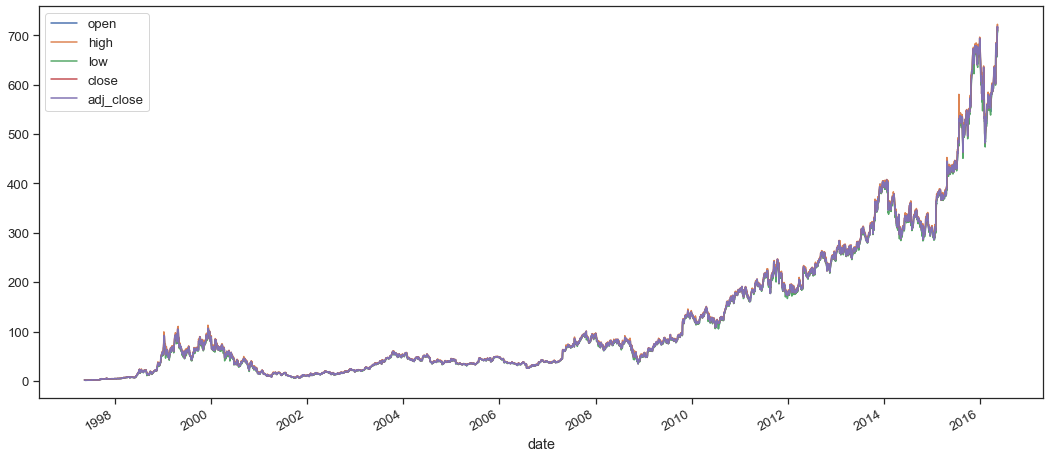

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='ticks', font_scale=1.2)

train.drop(columns=['volume']).plot(figsize=(18, 8))
plt.show()

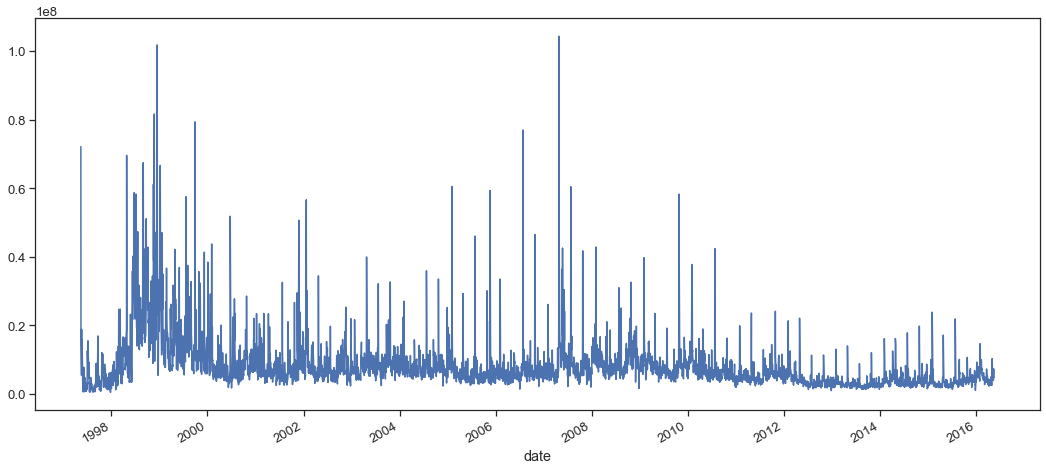

In [7]:
train.volume.plot(figsize=(18, 8))
plt.show()

In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(train.volume)
print('p-value', result[1])

p-value 5.379521019096599e-05


By simply inspecting the graph of price data, we can see that prices trend higher over time for AMZN, which means they are not stationary. The volume data appears to have some recurring peaks based on inspecting the graph. However, we use the Dickey-Fuller test, and we find that the p-value is far lower than 0.01, so we conclude that the volume is stationary. 

In [9]:
alpha = 0.01
diff_columns = []
for col in train.columns:
    # check if the difference is stationary
    d = train[col].diff().dropna()
    if  adfuller(d)[1] < alpha:
        diff_columns.append(col + '_diff')

diff_columns

['open_diff',
 'high_diff',
 'low_diff',
 'close_diff',
 'adj_close_diff',
 'volume_diff']

In [10]:
log_columns = []
for col in train.columns:
    # check if the logarithm is stationary
    d = np.log(train[col])
    if  adfuller(d)[1] < alpha:
        log_columns.append(col + '_log')
log_columns

['volume_log']

## Additional features
We can see from the stationarity exercise that we should check all of our features for stationarity if we want to use them in our forecasting model. We can include first differences for all the original columns and we can add the logarithm of volume. What other features might be useful for our model? Perhaps the daily difference between the high and the low or between any other combination of price variables.

In [23]:
# AMZN has never paid dividends ... is there any difference b/w the close and the adjusted close?
train['adjustment'] = train['close'] - train['adj_close']
print(f'percentage of dates with non-zero adjustment to close: {(train.adjustment != 0).mean():.3%}')
train.adjustment.abs().sort_values(ascending=False)[:10]

percentage of dates with non-zero adjustment to close: 0.000%


date
1997-05-15    0.0
2010-01-25    0.0
2010-01-21    0.0
2010-01-20    0.0
2010-01-19    0.0
2010-01-15    0.0
2010-01-14    0.0
2010-01-13    0.0
2010-01-12    0.0
2010-01-11    0.0
Name: adjustment, dtype: float64

In [24]:
train.drop(columns='adjustment', inplace=True)
# drop adj_close because it is no different from the close
diff_columns = [s for s in diff_columns if 'adj_close' not in s]
diff_columns

['open_diff', 'high_diff', 'low_diff', 'close_diff', 'volume_diff']

In [13]:
pairs = [
    ('open', 'close'),
    ('open', 'high'),
    ('open', 'low'),
    ('close', 'high'),
    ('close', 'low'),
    ('high', 'low')
]
intraday_columns = []
for s1, s2 in pairs:
    # subtract and check for stationarity
    d = train[s1] - train[s2]
    if  adfuller(d)[1] < alpha:
        intraday_columns.append(f'{s1}-{s2}')

intraday_columns

['open-close', 'open-low', 'close-high']

In [25]:
def derive_x(df, diff_columns, log_columns, intraday_columns):
    """
    Create features that are stationary. Remove features that are not stationary. 
    """
    if diff_columns:
        for col in diff_columns:
            df[col] = df[col.replace('_diff', '')].diff()
    
    if log_columns:
        for col in log_columns:
            df[col] = np.log(df[col.replace('_log', '')])

    if intraday_columns:
        for col in intraday_columns:
            s1, s2 = col.split('-')
            df[col] = df[s1] - df[s2]

    col2drop = ['open','close','high','low','adj_close']
    return df.drop(columns=[c for c in col2drop if c in df.columns]).dropna()

X_train = derive_x(train, diff_columns, log_columns, intraday_columns)
X_train.head()

,volume,open_diff,high_diff,low_diff,close_diff,volume_diff,volume_log,open-close,open-low,close-high
date,,,,,,,,,,
1997-05-16,14700000,-0.468750,-0.520833,-0.218750,-0.229166,-57456000.0,16.503358,0.239583,0.260417,-0.250000
1997-05-19,6106800,-0.208333,-0.208334,-0.083333,-0.020834,-8593200.0,15.624913,0.052084,0.135417,-0.062500
1997-05-20,5467200,-0.031250,-0.020833,0.010417,-0.072916,-639600.0,15.514277,0.093750,0.093750,-0.114583
1997-05-21,18853200,-0.093750,-0.104167,-0.260417,-0.208334,13386000.0,16.752193,0.208334,0.260417,-0.218750
1997-05-22,11776800,-0.197917,-0.197916,-0.062500,-0.031250,-7076400.0,16.281642,0.041667,0.125000,-0.052084


In [27]:
X_test = derive_x(test, diff_columns, log_columns, intraday_columns)
X_val = derive_x(val, diff_columns, log_columns, intraday_columns)

In [31]:
# keep the same rows for target variable
y_train = y_train[X_train.index]
y_test = y_test[X_test.index]
y_val = y_val[X_val.index]

## Model testing and hyperparameter optimization
Evaluation criterion is AUC

In [35]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

random_state = 42

models = [
    ('linear SVM', SVC(kernel='linear', C=0.025)),
    ('radial basis function SVM', SVC(gamma=2, C=1)),
    ('neural net', MLPClassifier(alpha=0.1, max_iter=1000, random_state=random_state)),
    ('nearest neighbor', KNeighborsClassifier()),
    ('decision tree', DecisionTreeClassifier(max_depth=5, random_state=random_state)),
    ('random forest', RandomForestClassifier(max_depth=5, random_state=random_state)),
    ('naive bayes', GaussianNB())
]

results = {'model': [], 'AUC': [], 'accuracy': []}
for name, clf in models:
    pipeline = make_pipeline(StandardScaler(), clf)
    pipeline.fit(X_train, y_train)
    results['model'].append(name)
    results['accuracy'].append(pipeline.score(X_test, y_test))
    try: 
        auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1])
    except:
        auc = roc_auc_score(y_test, pipeline.decision_function(X_test))
        
    results['AUC'].append(auc)

results = pd.DataFrame(results)
results.sort_values(by=['AUC','accuracy'], ascending=False)


,model,AUC,accuracy
0,linear SVM,0.892162,0.807157
5,random forest,0.857433,0.811133
4,decision tree,0.840784,0.819085
6,naive bayes,0.836677,0.624254
3,nearest neighbor,0.830974,0.803181
2,neural net,0.757919,0.679920
1,radial basis function SVM,0.636887,0.536779


In [45]:
# grid search for the optimal hyperparameters on the top 2 models
results = {'model': 'linear SVM', 'AUC': [], 
           'C': [1e-2, 0.1, 1, 10, 100, 1e3]}
for i in results['C']:
    pipeline = make_pipeline(StandardScaler(), SVC(C=i, kernel='linear'))
    pipeline.fit(X_train, y_train)
    auc = roc_auc_score(y_test, pipeline.decision_function(X_test))
    results['AUC'].append(auc)

results = pd.DataFrame(results)

records = []
param_grid = {'max_depth': [5, 25, 100], 'n_estimators': [100, 1e3]}
for d in param_grid['max_depth']:
    for n in param_grid['n_estimators']:
        pipeline = make_pipeline(
            StandardScaler(), 
            RandomForestClassifier(n_estimators=int(n), max_depth=d, random_state=random_state))
        pipeline.fit(X_train, y_train)
        auc = roc_auc_score(y_test, pipeline.predict_proba(X_test)[:,1])
        records.append({'max_depth': d, 'n_estimators': n, 'AUC': auc})
res = pd.DataFrame.from_records(records)
res.insert(0, 'model', 'random forest')

results = pd.concat([results, res])
results.sort_values(by=['AUC'], ascending=False)

,model,AUC,C,max_depth,n_estimators
4,linear SVM,0.897277,100.00,NaN,NaN
5,linear SVM,0.897277,1000.00,NaN,NaN
3,linear SVM,0.897071,10.00,NaN,NaN
2,linear SVM,0.897055,1.00,NaN,NaN
1,linear SVM,0.896657,0.10,NaN,NaN
0,linear SVM,0.889207,0.01,NaN,NaN
0,random forest,0.857433,NaN,5.0,100.0
1,random forest,0.854812,NaN,5.0,1000.0
2,random forest,0.847568,NaN,25.0,100.0
5,random forest,0.847520,NaN,100.0,1000.0


Based on AUC, the best model is linear SVM with C = 100

## Final model

In [46]:
# train on the train-test data with only the specified hyperparameters and model
pipeline = make_pipeline(StandardScaler(), SVC(C=100, kernel='linear'))
pipeline.fit(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]))

# test on validation set
accuracy = pipeline.score(X_val, y_val)
print(f'accuracy: {accuracy:.1%}')

auc = roc_auc_score(y_val, pipeline.decision_function(X_val))
print(f'area under ROC curve: {auc:.2f}')

accuracy: 80.9%
area under ROC curve: 0.91
